# Project 4: Naver movie sentiment classification


- Rubric

1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.	3가지 이상의 모델이 성공적으로 시도됨
2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.	gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함
3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.	네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

## Version check

In [76]:
import pandas as pd
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1) Data check

In [77]:
# Read data

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [78]:
train_data.info() # there are 5 nulls on document column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


## 2) Create data loader
* What it should contain
 #### data pre-pre-process part
 
    - 데이터의 중복 제거
    - NaN 결측치 제거
    - 한국어 토크나이저로 토큰화
    - 불용어(Stopwords) 제거
    
 #### string to dictionary part
 
    - 사전word_to_index 구성
    - 텍스트 스트링을 사전 인덱스 스트링으로 변환
    - X_train, y_train, X_test, y_test, word_to_index 리턴

In [79]:
# tools for tokenizer and stopwords
from collections import Counter
from konlpy.tag import Mecab
import numpy as np

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [80]:
# data pre-pre-process part

def process_data(data):
    data.drop_duplicates(subset=['document'], inplace=True)  # 데이터 중복 제거
    data = data.dropna(how = 'any')  # NaN 결측치 제거
    processed_data = []   
    for comment in data['document']:      # for each comments,
        tokenized_comment = tokenizer.morphs(comment)  # 한국어 토크나이저로 토큰화
        tokenized_comment = [token for token in tokenized_comment if not token in stopwords]  # 불용어(Stopwords) 제거
        processed_data.append(tokenized_comment)   # gather processed data
    return processed_data, np.array(list(data['label']))     # return words & target


# string to dictionary part & load

def load_data(train_data, test_data, num_words=10000):
    
    X_train, y_train = process_data(train_data)   # train data 전처리
    X_test, y_test = process_data(test_data)      # test data 전처리
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4) # 가장 빈번한 단어 계산 + 특수 단어 4개 제외
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    def wordlist_to_indexlist(wordlist):    # 사전word_to_index 구성
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]  #unknown으로 반환
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, y_train, X_test, y_test, word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [81]:
 # X_train : type -list, y_train : type - np.array

print(len(X_train), len(X_test)) 
print(len(y_train), len(y_test))
print(list(word_to_index.items())[:10]) # stopwords에 '다','하','을'이 없어서 살아남은걸 볼 수 있다

146182 49157
146182 49157
[('<PAD>', 0), ('<BOS>', 1), ('<UNK>', 2), ('<UNUSED>', 3), ('.', 4), ('영화', 5), ('다', 6), ('고', 7), ('하', 8), ('을', 9)]


## Word-index dict -> index-Word dict

In [82]:
# key - contents 의 역전
index_to_word = {index:word for word, index in word_to_index.items()}

print(list(index_to_word.items())[:10]) 

[(0, '<PAD>'), (1, '<BOS>'), (2, '<UNK>'), (3, '<UNUSED>'), (4, '.'), (5, '영화'), (6, '다'), (7, '고'), (8, '하'), (9, '을')]


## Encoding & Decoding functions for comments

In [83]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) Data analysis and engineering

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

max number of words:  116
[(7, 12441), (8, 11822), (6, 11741), (9, 10907), (10, 10287), (5, 9580), (11, 9531), (12, 8928), (13, 8253), (14, 7868), (15, 7440), (4, 6936), (16, 6823), (17, 6258), (18, 5535), (3, 4951), (19, 4869), (20, 4312), (21, 3746), (22, 3136), (23, 2653), (2, 2554), (24, 2242), (25, 1993), (26, 1688), (27, 1512), (28, 1376), (29, 1270), (30, 1241), (31, 1108), (32, 1074), (1, 1015), (34, 951), (33, 947), (35, 927), (37, 854), (36, 814), (38, 763), (40, 728), (39, 714)]


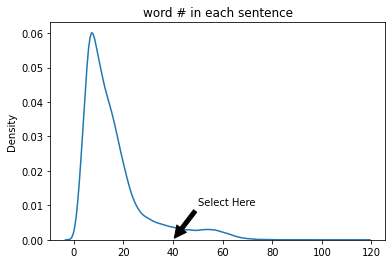

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt

total_list = X_train + X_test
words_in_X = [len(s) for s in total_list]
print('max number of words: ', max(words_in_X))
print(Counter(words_in_X).most_common(40))

plt.title('word # in each sentence')
sns.kdeplot(data= words_in_X)
plt.annotate('Select Here', xy=(40, 0), xytext=(50, 0.01), arrowprops=dict(facecolor='black', shrink=0.05))
plt.show()


- max token selection : 40

In [85]:
max_tokens = 40

### Set sentences into length of max_tokens

In [86]:
# 최대길이(max_tokens)에 맞춰서 긴 문장은 잘라내고, 부족한 것은 앞에 공백 덭대기
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train = pad_sequences(X_train, value=word_to_index["<PAD>"], padding='pre', maxlen=max_tokens)

X_test = pad_sequences(X_test, value=word_to_index["<PAD>"], padding='pre', maxlen=max_tokens)

print(X_train.shape)
print(type(X_train))
print(X_train[:10])
# 'pre' 에 pad를 덭대는 이유는 rnn계열의 신경망은 나중에 들어오는 
# input에 대해서 강하게 영향 받기 때문

(146182, 40)
<class 'numpy.ndarray'>
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0   32   74  919    4    4   39  228   20   33  748]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0 1028    4   11  519  549
   687    5  120    4   70 1639   52  925 1006   15   44  391]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0   24  205    2]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0 8409
   158 3925    4    4  298   94   17    6    4    4   58 3479]
 [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    2 8894 1108   52 2832   60    5   14 2758  

## 4) 모델 구성 및 validation set 구성



In [ ]:
vocab_size = 10000       # 단어 주머니 10000개
word_vector_dim = 50     # 각 토큰별 특성 갯수

### 1. RNN model (LSTM)

In [158]:
import tensorflow as tf

class RNN(tf.keras.Model):
    def __init__(self):
        super(RNN, self).__init__()
        
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim)
        self.lstm_layer = tf.keras.layers.LSTM(8)
        self.dense_layer1 = tf.keras.layers.Dense(8, activation='relu')
        self.dense_layer2 = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x = self.embedding_layer(inputs)
        x = self.lstm_layer(x)
        x = self.dense_layer1(x)
        x = self.dense_layer2(x)
        return x

### 2. 1-D CNN model

In [159]:
class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.conv1d_layer1 = tf.keras.layers.Conv1D(16, 6, strides=1, activation='relu')
        self.maxpooling1d_layer = tf.keras.layers.MaxPooling1D(5)
        self.conv1d_layer2 = tf.keras.layers.Conv1D(32, 6, strides=1, activation='relu')
        self.globalmaxpooling1d_layer = tf.keras.layers.GlobalMaxPooling1D()
        self.dense_layer1 = tf.keras.layers.Dense(32, activation='relu')
        self.dense_layer2 = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x = self.embedding_layer(inputs)
        x = self.conv1d_layer1(x)
        x = self.maxpooling1d_layer(x)
        x = self.conv1d_layer2(x)
        x = self.globalmaxpooling1d_layer(x)
        x = self.dense_layer1(x)
        x = self.dense_layer2(x)
        return x

### 3. GlobalMaxPooling1D

In [160]:
class GlobalMaxPooling(tf.keras.Model):
    def __init__(self):
        super(GlobalMaxPooling, self).__init__()
        
        self.embedding_layer = tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
        self.globalmaxpooling1d_layer = tf.keras.layers.GlobalMaxPooling1D()
        self.dense_layer1 = tf.keras.layers.Dense(8, activation='relu')
        self.dense_layer2 = tf.keras.layers.Dense(1, activation='sigmoid')
        
    def call(self, inputs):
        x = self.embedding_layer(inputs)
        x = self.globalmaxpooling1d_layer(x)
        x = self.dense_layer1(x)
        x = self.dense_layer2(x)
        return x

### Validation set 구성
훈련용 데이터셋 25000건 중 10000건을 분리하여 검증셋(validation set)으로 사용

In [161]:
# validation set 10000건 분리
X_val = X_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 40)
(136182,)


## 5) 모델 훈련 개시

In [162]:
RNN_model = RNN()
CNN_model = CNN()
GlobalMaxPooling_model = GlobalMaxPooling()

models = [RNN_model, CNN_model, GlobalMaxPooling_model]  # 모델 다발 생성

for model in models:
    model.build(input_shape=(512, 40))  # input_shape (batch size, token length)
    model.summary()

Model: "rnn_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_18 (Embedding)     multiple                  1000000   
_________________________________________________________________
lstm_6 (LSTM)                multiple                  3488      
_________________________________________________________________
dense_36 (Dense)             multiple                  72        
_________________________________________________________________
dense_37 (Dense)             multiple                  9         
Total params: 1,003,569
Trainable params: 1,003,569
Non-trainable params: 0
_________________________________________________________________
Model: "cnn_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     multiple                  1000000   
____________________________________

In [163]:
epochs=20
rnn_history = None
cnn_history = None
max_history = None
for model in models:
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)
    if model == RNN_model:
        rnn_history = history.history.copy()
    elif model == CNN_model:
        cnn_history = history.history.copy()
    else:
        max_history = history.history.copy()

Epoch 1/20
266/266 [==============================] - 4s 7ms/step - loss: 0.4480 - accuracy: 0.7972 - val_loss: 0.3476 - val_accuracy: 0.8497
Epoch 2/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3276 - accuracy: 0.8630 - val_loss: 0.3367 - val_accuracy: 0.8511
Epoch 3/20
266/266 [==============================] - 2s 6ms/step - loss: 0.3012 - accuracy: 0.8752 - val_loss: 0.3398 - val_accuracy: 0.8553
Epoch 4/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2809 - accuracy: 0.8855 - val_loss: 0.3424 - val_accuracy: 0.8556
Epoch 5/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2625 - accuracy: 0.8941 - val_loss: 0.3434 - val_accuracy: 0.8552
Epoch 6/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2449 - accuracy: 0.9012 - val_loss: 0.3527 - val_accuracy: 0.8563
Epoch 7/20
266/266 [==============================] - 2s 6ms/step - loss: 0.2273 - accuracy: 0.9089 - val_loss: 0.3591 - val_accuracy: 0.8546
Epoch 

266/266 [==============================] - 1s 4ms/step - loss: 0.0139 - accuracy: 0.9958 - val_loss: 0.8488 - val_accuracy: 0.8270
Epoch 19/20
266/266 [==============================] - 1s 4ms/step - loss: 0.0125 - accuracy: 0.9960 - val_loss: 0.8794 - val_accuracy: 0.8248
Epoch 20/20
266/266 [==============================] - 1s 4ms/step - loss: 0.0110 - accuracy: 0.9962 - val_loss: 0.9066 - val_accuracy: 0.8274


### 각 모델에 대한 평가 (evaluation)

In [174]:
loss = []
accuracy = []
i = 0

for model in models:
    results = model.evaluate(X_test, y_test, verbose=2)
    loss.append(results[0])
    accuracy.append(results[1])

acc_per = np.array(accuracy) * 100

for model in models:
    model_name = type(model).__name__
    print(f"{model_name}의 loss는 {loss[i]:.4f}, accuracy는 {acc_per[i]:.2f}%")
    i += 1

1537/1537 - 3s - loss: 0.6253 - accuracy: 0.8397
1537/1537 - 3s - loss: 1.3340 - accuracy: 0.8292
1537/1537 - 2s - loss: 0.8945 - accuracy: 0.8262
RNN의 loss는 0.6253, accuracy는 83.97%
CNN의 loss는 1.3340, accuracy는 82.92%
GlobalMaxPooling의 loss는 0.8945, accuracy는 82.62%


- RNN(LSTM) loss는 0.6253, accuracy는 83.97%
- CNN(1-D) loss는 1.3340, accuracy는 82.92%
- GlobalMaxPooling(1-D)의 loss는 0.8945, accuracy는 82.62%

accuracy < 85% (need better model)

## 6) Loss, Accuracy 그래프 시각화

In [175]:
histories = [rnn_history, cnn_history, max_history]

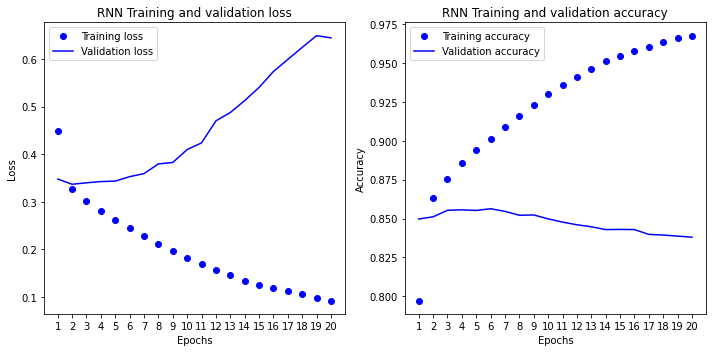

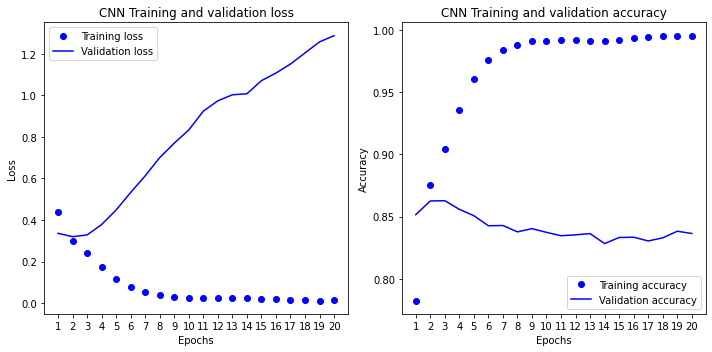

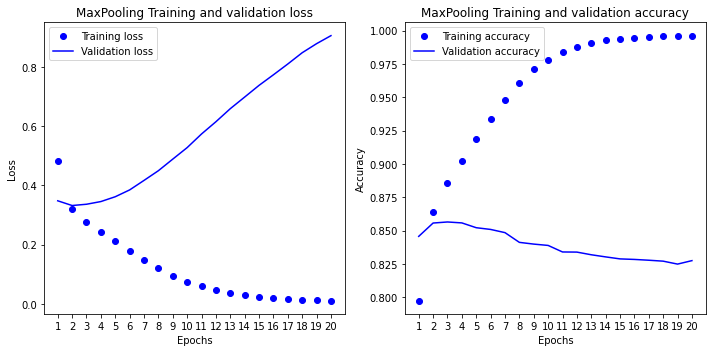

In [184]:
titles = ['RNN', 'CNN', 'MaxPooling']
for i, history in enumerate(histories):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

     # 그래프 크기를 조절
    plt.figure(figsize=(10, 5))

    
    plt.subplot(1, 2, 1)
    # "bo" 파란점
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # "b" 파란선
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(titles[i] + ' Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, len(epochs) + 1))  # 에포크를 정수로 표시
    plt.legend()

    plt.subplot(1, 2, 2)
    # "bo" 파란점
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    # "b" 파란선
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(titles[i] + ' Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(epochs) + 1))  # 에포크를 정수로 표시
    plt.legend()

    plt.tight_layout()
    plt.show()


이미 에포크 2~3 쯤에서 train과 validation이 이별하고 있다, 괴리가 커지고 있다, overfitting 되고 있다

## 7) 학습된 Embedding 레이어 분석

In [189]:
for model in models:
    embedding_layer = model.layers[0]
    weights = embedding_layer.get_weights()[0]
    model_name = type(model).__name__
    print('embedding layer', model_name , ': ',weights.shape)

embedding layer RNN :  (10000, 100)
embedding layer CNN :  (10000, 100)
embedding layer GlobalMaxPooling :  (10000, 100)


In [192]:
def save_embedding_parameters(models, titles, index_to_word, vocab_size, word_vector_dim):
    for i, model in enumerate(models):
        # 학습한 Embedding 파라미터를 파일에 써서 저장합니다.
        word2vec_file_path = f'./data/word2vec_{titles[i]}.txt'
        f = open(word2vec_file_path, 'w')
        f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

        # 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다.
        vectors = model.get_weights()[0]
        for i in range(4, vocab_size):
            f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
        f.close()
        
save_embedding_parameters(models, titles, index_to_word, vocab_size, word_vector_dim)

In [197]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 각 모델들이 생각하는 '꿈'과 근접한 단어들 찾기
for title in titles:
    word2vec_file_path = f'./data/word2vec_{title}.txt'
    word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
    print(title, '<- 꿈')  
    print(word_vectors.similar_by_word("꿈"))

RNN <- 꿈
[('쩔', 0.7698253393173218), ('구름', 0.7562309503555298), ('탁월', 0.7550910115242004), ('프리퀄', 0.7510617971420288), ('작살', 0.7483425736427307), ('인피니트', 0.7482423186302185), ('기다려', 0.7480387687683105), ('오스카', 0.7460688352584839), ('귀여워', 0.7449714541435242), ('작인', 0.7439958453178406)]
CNN <- 꿈
[('훈훈', 0.5020228624343872), ('광해', 0.4880295693874359), ('해적', 0.4731029272079468), ('헷', 0.46603095531463623), ('무장', 0.45536357164382935), ('계속', 0.4504358470439911), ('기에', 0.44984549283981323), ('저희', 0.44813358783721924), ('이제훈', 0.4414142370223999), ('미남', 0.4412880837917328)]
MaxPooling <- 꿈
[('최근', 0.6569418907165527), ('박진감', 0.6500723958015442), ('서', 0.633328914642334), ('기억', 0.6247753500938416), ('것', 0.6033563017845154), ('예요', 0.597682774066925), ('역사', 0.5888252854347229), ('대한', 0.5834084749221802), ('캐릭터', 0.5804548859596252), ('영상미', 0.5776968598365784)]


- 통일성, 유사성이 떨어진다는것을 확인

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선


In [103]:
from gensim.models import Word2Vec

word2vec_file_path = './data/word2vec_ko.model'

word_vectors = Word2Vec.load(word2vec_file_path)  # pretrained embedding model load


(100,)

In [104]:
vector = word_vectors.wv['잠']
vector.shape 

# 각 단어는 100개의 차원으로 vectorize 됨을 확인

(100,)

In [105]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수 
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

In [106]:
embedding_matrix.shape         

(10000, 100)

In [128]:
print(index_to_word[4], '\n' ,embedding_matrix[4])    # '.' 이 벡터로 변한 형태

. 
 [ 1.0148797  -0.50785506 -3.01209021  0.45532331  1.18936408  1.16196549
  2.0690465  -0.4041273  -3.67824864  5.15002871 -4.90728283 -1.17444587
 -2.04329658 -0.27965945 -3.60060024  3.71831751  1.4845506   0.3471984
  3.05809855 -2.98130846 -2.75871563  1.69519937 -0.62313354 -2.48172998
  1.7739619   0.90663171  3.50179338 -4.62058544 -2.70127892  0.75214028
 -6.49481773  3.31358528  0.79373801  3.56094408  0.5049091   2.51798296
  1.08281338  2.22650957 -0.54819411 -2.45683312  5.82740164 -0.48938593
  7.21801424 -0.25775084 -0.69435704 -0.57397074 -0.9460867   3.64878941
 -0.61506265 -4.03338385  0.41044739 -0.03049513  0.09765369 -5.68309593
  1.61000216  1.61402714 -0.35847089  0.99730688  1.03616691 -3.59692454
  0.92260575  0.27273268  1.30361199 -0.35995319 -2.94048095 -1.03001702
  3.20227623 -5.205935    2.38758183 -3.1253984   1.00584948 -1.81666231
  4.36685753 -4.05125952 -0.36159644 -0.69638383  1.12456954 -0.62755346
  0.2120384  -4.40245962 -2.05257916 -3.70964599

In [125]:
print(index_to_word[5], '\n' ,embedding_matrix[5])    # '영화' 가 벡터로 변한 형태

영화 
 [-1.80073893 -1.1790098  -2.4066596   2.13841558 -0.3537603   1.37495267
 -4.89461184 -3.65171981  0.44114441  0.78153926 -2.69688797 -1.78128517
 -2.15146542 -4.81323624  2.74659181 -2.16203237 -0.11467794 -1.24311709
  2.39793086 -1.10606277 -0.41043055  1.95003915  0.7821002   1.58999777
  1.6447444  -2.12650347 -1.79815948  1.7535795   0.53717697 -1.21212101
 -4.46631622  4.54883242  1.33444095 -0.90702713  1.19318891  4.15632153
  1.97583067 -0.94375622 -0.25927249  0.34935686  1.85628748 -3.32496452
  1.12216246  1.28365242  3.92113757  3.8023994   2.76626897  0.67293745
  2.28536439 -5.11317158  0.32525915 -3.3079958   5.30435133 -3.88137579
 -0.32960036 -1.95275044  3.88650751 -3.54703784 -0.21991685  0.82119733
 -0.94924921  3.54721069  1.32204795 -0.70640826  0.52253807  1.46832347
 -1.10186887  2.26294088 -0.72046852 -1.76620102  5.22375774  3.0748682
  1.09775758  3.31917334 -0.41004229 -1.7022891  -0.78379875  0.82586575
 -0.54520637  1.23553824  2.02674007 -0.6524469

In [200]:
#RNN에 사전 훈련된 embedding layer 적용
RNN_with_embedding = RNN()

fake_input = np.zeros((1, 40))
# 가짜 입력 데이터를 통과시켜 모델을 초기화합니다
RNN_with_embedding.predict(fake_input)
# 사전 훈련된 임베딩을 임베딩 레이어에 적용합니다
RNN_with_embedding.embedding_layer.set_weights([embedding_matrix])
# 임베딩 레이어를 학습 불가능 상태로 설정합니다
RNN_with_embedding.embedding_layer.trainable = False


#CNN에 사전 훈련된 embedding layer 적용
CNN_with_embedding = CNN()

fake_input = np.zeros((1, 40))
# 가짜 입력 데이터를 통과시켜 모델을 초기화합니다
CNN_with_embedding.predict(fake_input)
# 사전 훈련된 임베딩을 임베딩 레이어에 적용합니다
CNN_with_embedding.embedding_layer.set_weights([embedding_matrix])
# 임베딩 레이어를 학습 불가능 상태로 설정합니다
CNN_with_embedding.embedding_layer.trainable = False


#GlobalMaxPooling에 사전 훈련된 embedding layer 적용
Maxpooling_with_embedding = GlobalMaxPooling()

fake_input = np.zeros((1, 40))
# 가짜 입력 데이터를 통과시켜 모델을 초기화합니다
Maxpooling_with_embedding.predict(fake_input)
# 사전 훈련된 임베딩을 임베딩 레이어에 적용합니다
Maxpooling_with_embedding.embedding_layer.set_weights([embedding_matrix])
# 임베딩 레이어를 학습 불가능 상태로 설정합니다
Maxpooling_with_embedding.embedding_layer.trainable = False


In [202]:
embedded_models = [RNN_with_embedding, CNN_with_embedding, Maxpooling_with_embedding]

epochs=20 
e_rnn_history = None
e_cnn_history = None
e_max_history = None

for model in embedded_models:
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    history = model.fit(partial_X_train, partial_y_train, epochs=epochs, batch_size=512, validation_data=(X_val, y_val), verbose=1)
    if model == RNN_with_embedding:
        e_rnn_history = history.history.copy()
    elif model == CNN_with_embedding:
        e_cnn_history = history.history.copy()
    else:
        e_max_history = history.history.copy()

Epoch 1/20
266/266 [==============================] - 3s 6ms/step - loss: 0.6256 - accuracy: 0.6433 - val_loss: 0.5355 - val_accuracy: 0.7357
Epoch 2/20
266/266 [==============================] - 1s 5ms/step - loss: 0.5021 - accuracy: 0.7583 - val_loss: 0.4803 - val_accuracy: 0.7718
Epoch 3/20
266/266 [==============================] - 1s 5ms/step - loss: 0.4682 - accuracy: 0.7799 - val_loss: 0.4574 - val_accuracy: 0.7820
Epoch 4/20
266/266 [==============================] - 1s 5ms/step - loss: 0.4506 - accuracy: 0.7891 - val_loss: 0.4422 - val_accuracy: 0.7916
Epoch 5/20
266/266 [==============================] - 1s 5ms/step - loss: 0.4395 - accuracy: 0.7953 - val_loss: 0.4353 - val_accuracy: 0.7958
Epoch 6/20
266/266 [==============================] - 1s 5ms/step - loss: 0.4306 - accuracy: 0.8015 - val_loss: 0.4299 - val_accuracy: 0.7974
Epoch 7/20
266/266 [==============================] - 1s 5ms/step - loss: 0.4244 - accuracy: 0.8051 - val_loss: 0.4215 - val_accuracy: 0.8026
Epoch 

266/266 [==============================] - 1s 3ms/step - loss: 0.6018 - accuracy: 0.6718 - val_loss: 0.6110 - val_accuracy: 0.6649
Epoch 19/20
266/266 [==============================] - 1s 3ms/step - loss: 0.6014 - accuracy: 0.6722 - val_loss: 0.6101 - val_accuracy: 0.6644
Epoch 20/20
266/266 [==============================] - 1s 3ms/step - loss: 0.6015 - accuracy: 0.6725 - val_loss: 0.6086 - val_accuracy: 0.6662


In [203]:
loss = []
accuracy = []
i = 0

for model in embedded_models:
    results = model.evaluate(X_test, y_test, verbose=2)
    loss.append(results[0])
    accuracy.append(results[1])

acc_per = np.array(accuracy) * 100

for model in embedded_models:
    model_name = type(model).__name__
    print(f"embedded {model_name}의 loss는 {loss[i]:.4f}, accuracy는 {acc_per[i]:.2f}%")
    i += 1

1537/1537 - 3s - loss: 0.4067 - accuracy: 0.8142
1537/1537 - 3s - loss: 0.4568 - accuracy: 0.7926
1537/1537 - 2s - loss: 0.6029 - accuracy: 0.6734
embedded RNN의 loss는 0.4067, accuracy는 81.42%
embedded CNN의 loss는 0.4568, accuracy는 79.26%
embedded GlobalMaxPooling의 loss는 0.6029, accuracy는 67.34%


임베딩을 하고나서 오히려 동일조건 대비 20에포크 까지에서는 정확도가 모든 모델에서 떨어졌다

validation을 확인해 봐야겠다

In [206]:
e_histories = [e_rnn_history, e_cnn_history, e_max_history]

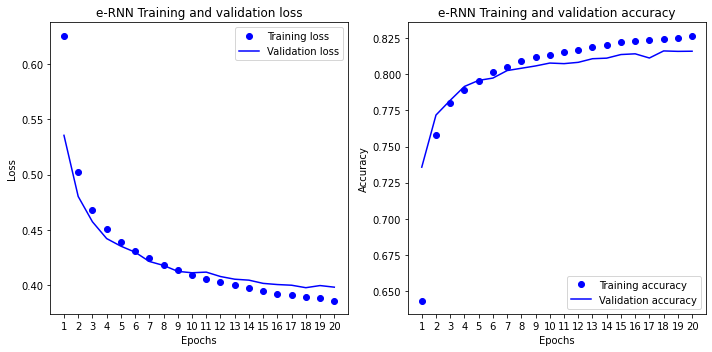

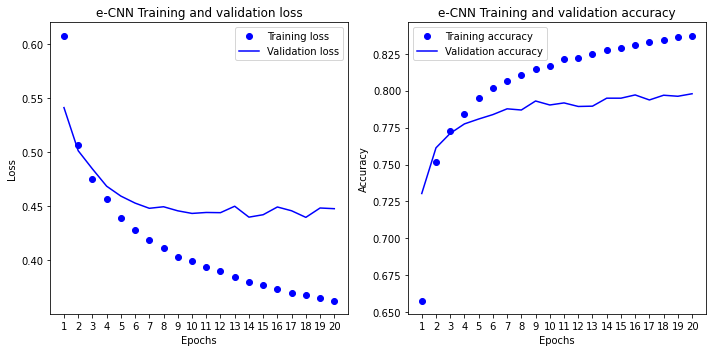

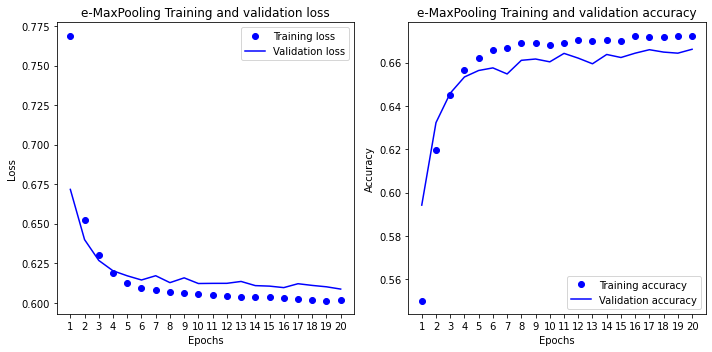

In [207]:
e_titles = ['e-RNN', 'e-CNN', 'e-MaxPooling']
for i, history in enumerate(e_histories):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs = range(1, len(acc) + 1)

     # 그래프 크기를 조절
    plt.figure(figsize=(10, 5))

    
    plt.subplot(1, 2, 1)
    # "bo" 파란점
    plt.plot(epochs, loss, 'bo', label='Training loss')
    # "b" 파란선
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(e_titles[i] + ' Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.xticks(range(1, len(epochs) + 1))  # 에포크를 정수로 표시
    plt.legend()

    plt.subplot(1, 2, 2)
    # "bo" 파란점
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    # "b" 파란선
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title(e_titles[i] + ' Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.xticks(range(1, len(epochs) + 1))  # 에포크를 정수로 표시
    plt.legend()

    plt.tight_layout()
    plt.show()

embedded layer가 포함된 RNN과 GlobalMaxpooling 모델은 validation 이 train 을 잘 따라왔다. 

-> 에포크를 늘려서 성능 향상을 기대할 수 있겠다